### Concordance Breakdown by Modality

**Purpose:** Visualize diagnostic performance across modalities.

**Plot:** Grouped bar chart showing % of:
- Exact matches
- Side-only matches
- Incorrect localizations

**Use:** Highlights each modality’s precision for quick comparison in analysis and manuscript figures.

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
preop_imaging_df = pd.read_excel('../../Data/imaging_data.xlsx')

In [5]:
# Define modality
modalities = ['SPECT/CT', '4D CT Scan', 'Ultrasound', 'Sestamibi', 'MRI']

def check_concordance(row, modality_col):
    imaging = row[modality_col]
    surgical = row['Surgical Findings']
    
    if pd.isnull(imaging) or pd.isnull(surgical):
        return 'Unknown'
    
    if imaging in ['No Scan', 'Non-localizing']:
        return 'Non-localizing'
    
    imaging_glands = [g.strip() for g in imaging.split(',')]
    surgical_glands = [g.strip() for g in surgical.split(',')]
    
    # Exact gland match
    if any(sg in imaging_glands for sg in surgical_glands):
        return 'Yes (Exact)'
    
    # Side match
    imaging_sides = ['Left' for ig in imaging_glands if 'Left' in ig] + \
                    ['Right' for ig in imaging_glands if 'Right' in ig]
    surgical_sides = ['Left' for sg in surgical_glands if 'Left' in sg] + \
                     ['Right' for sg in surgical_glands if 'Right' in sg]
    
    if any(side in surgical_sides for side in imaging_sides):
        return 'Yes (Side)'
    
    return 'Incorrect Localization'



In [6]:
for modality in modalities:
    concordance_col = modality + ' Calculated Concordance'
    preop_imaging_df[concordance_col] = preop_imaging_df.apply(
        lambda row: check_concordance(row, modality), axis=1
    )

# Initialize summary data list
summary_data = []

# Loop through modalities and collect counts + percentages, excluding Unknown and Non-localizing
for modality in modalities:
    concordance_col = modality + ' Calculated Concordance'
    
    # Filter to localizing rows only
    localizing_df = preop_imaging_df[
        ~preop_imaging_df[concordance_col].isin(['Unknown', 'Non-localizing'])
    ].copy()
    
    counts = localizing_df[concordance_col].value_counts()
    total = counts.sum()
    
    for match_type, count in counts.items():
        pct = (count / total) * 100 if total > 0 else 0
        
        summary_data.append({
            'Modality': modality,
            'Concordance': match_type,
            'Count': count,
            'Percentage': pct
        })

In [7]:
# Convert to DataFrame
concordance_summary_df = pd.DataFrame(summary_data)

# Pivot for grouped bar plot preparation (optional)
pivot_df = concordance_summary_df.pivot(index='Modality', columns='Concordance', values='Percentage').fillna(0)

# Reorder columns if needed
ordered_cols = ['Yes (Exact)', 'Yes (Side)', 'Incorrect Localization']
pivot_df = pivot_df.reindex(columns=ordered_cols).fillna(0)

# Display results
display(concordance_summary_df)
display(pivot_df)

,Modality,Concordance,Count,Percentage
0,SPECT/CT,Yes (Exact),83,46.629213
1,SPECT/CT,Yes (Side),80,44.943820
2,SPECT/CT,Incorrect Localization,15,8.426966
3,4D CT Scan,Yes (Exact),90,52.023121
4,4D CT Scan,Yes (Side),56,32.369942
5,4D CT Scan,Incorrect Localization,27,15.606936
6,Ultrasound,Yes (Side),36,46.153846
7,Ultrasound,Yes (Exact),31,39.743590
8,Ultrasound,Incorrect Localization,11,14.102564
9,Sestamibi,Yes (Side),60,53.097345


Concordance,Yes (Exact),Yes (Side),Incorrect Localization
Modality,,,
4D CT Scan,52.023121,32.369942,15.606936
MRI,50.000000,25.000000,25.000000
SPECT/CT,46.629213,44.943820,8.426966
Sestamibi,46.017699,53.097345,0.884956
Ultrasound,39.743590,46.153846,14.102564


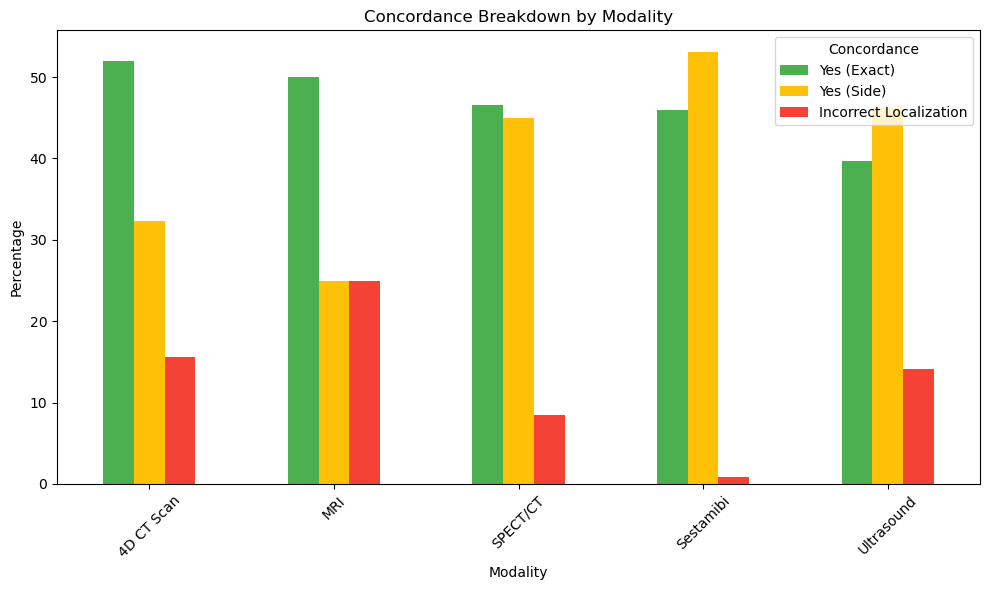

In [8]:
# Plot grouped bar plot
pivot_df.plot(
    kind='bar',
    figsize=(10,6),
    color=['#4CAF50', '#FFC107', '#F44336']  # green, yellow, red
)

plt.ylabel('Percentage')
plt.title('Concordance Breakdown by Modality')
plt.xticks(rotation=45)
plt.legend(title='Concordance')
plt.tight_layout()
plt.show()

In [9]:
for modality in modalities:
    concordance_col = modality + ' Calculated Concordance'
    
    # Filter to localizing rows only
    localizing_df = preop_imaging_df[
        ~preop_imaging_df[concordance_col].isin(['Unknown', 'Non-localizing'])
    ].copy()
    
    counts = localizing_df[concordance_col].value_counts()
    total = counts.sum()
    
    for match_type, count in counts.items():
        pct = (count / total) * 100 if total > 0 else 0
        
        summary_data.append({
            'Modality': modality,
            'Concordance': match_type,
            'Count': count,
            'Percentage': pct
        })

In [10]:
# Initialize dictionaries to store results
non_localizing_counts = {}
localizing_counts = {}
non_localization_rates = {}
localization_rates = {}

for modality in modalities:
    # Count non-localizing
    non_localizing_count = preop_imaging_df[preop_imaging_df[modality] == 'Non-localizing'].shape[0]
    non_localizing_counts[modality] = non_localizing_count

    # Count localizing (not Non-localizing and not NaN)
    localizing_count = preop_imaging_df[
        preop_imaging_df[modality].notnull() & 
        (preop_imaging_df[modality] != 'Non-localizing') & 
        (preop_imaging_df[modality] != 'No Scan')
    ].shape[0]
    localizing_counts[modality] = localizing_count

    # Calculate total scans with data
    total = non_localizing_count + localizing_count

    # Calculate non-localization rate
    non_localization_rates[modality] = round((non_localizing_count / total * 100) if total > 0 else 0, 2)
    localization_rates[modality] = round((localizing_count / total * 100) if total > 0 else 0, 2)


# Convert to DataFrame
summary_df = pd.DataFrame({
    'Non-localizing': pd.Series(non_localizing_counts),
    'Localizing': pd.Series(localizing_counts),
    'Non-localization Rate (%)': pd.Series(non_localization_rates),
    'Localization Rate (%)': pd.Series(localization_rates)
})

display(summary_df)

,Non-localizing,Localizing,Non-localization Rate (%),Localization Rate (%)
SPECT/CT,52,178,22.61,77.39
4D CT Scan,55,173,24.12,75.88
Ultrasound,67,78,46.21,53.79
Sestamibi,61,113,35.06,64.94
MRI,7,8,46.67,53.33


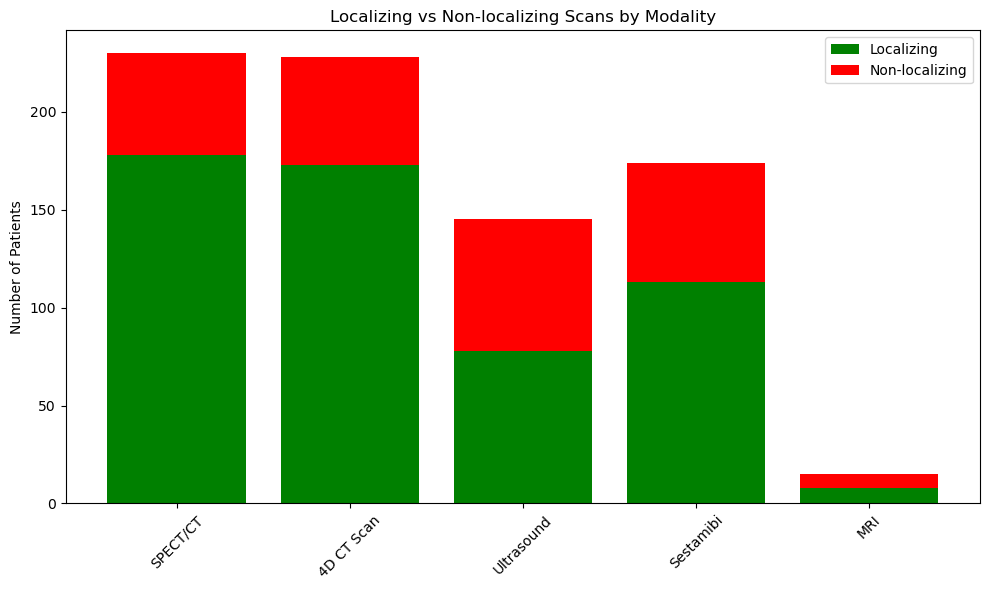

In [11]:
# Convert to Series
localizing_series = pd.Series(localizing_counts)
non_localizing_series = pd.Series(non_localizing_counts)

modalities = localizing_series.index.tolist()

plt.figure(figsize=(10,6))

# Bar plots with .values for y-axis heights
plt.bar(modalities, localizing_series.values, label='Localizing', color='green')
plt.bar(modalities, non_localizing_series.values, bottom=localizing_series.values, label='Non-localizing', color='red')

plt.ylabel('Number of Patients')
plt.title('Localizing vs Non-localizing Scans by Modality')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()